<h1>eICU Treatment Disparities, Stratified by Race</h1>
The code can stand to be cleaned up, but it generates the figures from the poster.

In [1]:
##################
# Load data
##################

import pandas as pd
import psycopg2
import time

print time.strftime("%Y-%m-%d %H:%M:%S")

# create a database connection
sqluser = 'saadtech'
dbname = 'eicu'
schema_name = 'eicu_crd'


# Connect to the database
con = psycopg2.connect(dbname=dbname, user=sqluser, host="/var/run/postgresql")
cur = con.cursor()
cur.execute('SET search_path to {}'.format(schema_name))


# Loading data. Takes a little bit, but then you have it all session (worth it)

# hospitals
hospital_query = "select distinct patientunitstayid,hospitalid,hospitaldischargelocation as discharge_location from patient where hospitaldischargelocation in ('Skilled Nursing Facility','Death')"

all_hospitals = pd.read_sql_query(hospital_query, con)
good_hospital_ids = [79, 83, 86, 90, 91, 92, 94, 95, 96, 102, 108, 110, 112, 120, 122, 123, 125, 135, 140, 142, 146, 148, 152, 154, 155, 156, 157, 158, 165, 167, 171, 174, 175, 176, 199, 200, 201, 202, 203, 204, 206, 207, 208, 209, 210, 226, 243, 248, 249, 250, 252, 253, 265, 271, 272, 275, 280, 281, 283, 323, 350, 352, 353, 358, 360, 363, 364, 365, 384, 388, 390, 393, 403, 405, 411, 413, 416, 417, 443, 444, 447, 449, 458, 459]
hospitals = all_hospitals.loc[all_hospitals['hospitalid'].isin(good_hospital_ids)]
print 'hospitals: ', hospitals.shape
#display(hospitals.head())
print

# outcome
apache_query = 'select distinct patientunitstayid,apacheScore,actualhospitallos as los from apachepatientresult'
apache = pd.read_sql_query(apache_query, con)
print 'apache: ', apache.shape
#display(apache.head())
print

# demographics
demographics_query = """
select distinct patientUnitStayID,patienthealthsystemstayid,gender,age,ethnicity as race 
from patient 
where ethnicity in ('Caucasian','African American')
and gender in ('Male', 'Female')
"""
demographics = pd.read_sql_query(demographics_query, con)
def age_to_num(age):
    try:
        return int(age)
    except Exception as e:
        return 90
demographics['age'] = demographics['age'].apply(age_to_num)
print 'demographics: ', demographics.shape
#display(demographics.head())
print

# treatment strings
treatment_query = 'select distinct patientunitstayid,treatmentid,treatmentoffset,treatmentstring from treatment'
treatments = pd.read_sql_query(treatment_query, con)
print 'treatments: ', treatments.shape
#display(treatments.head())
print

print
icustay_ids = set(hospitals['patientunitstayid']) & set(demographics['patientunitstayid']) & \
              set(   apache['patientunitstayid']) & set(  treatments['patientunitstayid']) 
print '[stays] ids:   ', len(icustay_ids)
print

# filter down to the relevant patients
hospitals    =    hospitals.loc[   hospitals['patientunitstayid'].isin(icustay_ids)]
demographics = demographics.loc[demographics['patientunitstayid'].isin(icustay_ids)]
apache       =       apache.loc[      apache['patientunitstayid'].isin(icustay_ids)]
treatments   =   treatments.loc[  treatments['patientunitstayid'].isin(icustay_ids)]

print 'hospitals:    rows=%7d stays=%5d' % (len(hospitals)   , len(set(   hospitals['patientunitstayid'].values)))
print 'demographics: rows=%7d stays=%5d' % (len(demographics), len(set(demographics['patientunitstayid'].values)))
print 'apache:       rows=%7d stays=%5d' % (len(apache)      , len(set(      apache['patientunitstayid'].values)))
print 'treatments:   rows=%7d stays=%5d' % (len(treatments)  , len(set(  treatments['patientunitstayid'].values)))

print time.strftime("%Y-%m-%d %H:%M:%S")

2025-05-05 18:51:11
hospitals:  (23760, 3)

apache:  (148532, 3)

demographics:  (176575, 5)

treatments:  (3688745, 4)


[stays] ids:    14408

hospitals:    rows=  14408 stays=14408
demographics: rows=  14408 stays=14408
apache:       rows=  14408 stays=14408
treatments:   rows= 520063 stays=14408
2025-05-05 18:51:21


In [2]:
print time.strftime("%Y-%m-%d %H:%M:%S")

import tqdm

##################
# Helper aggregates
##################

# map ICU stay to race
races = {}
for i,row in tqdm.tqdm(demographics.iterrows()):
    if row.race == 'African American':
        races[row.patientunitstayid] = 'Black'
    elif row.race == 'Caucasian':
        races[row.patientunitstayid] = 'White'
print len(races)

# map ICU stay to acuity
severities = {}
for i,row in tqdm.tqdm(apache.iterrows()):
    severities[row.patientunitstayid] = row.apachescore  
print len(severities)

print time.strftime("%Y-%m-%d %H:%M:%S")

622it [00:00, 6212.93it/s]

2025-05-05 18:51:46


14408it [00:02, 6518.09it/s]
889it [00:00, 8888.40it/s]

14408


14408it [00:01, 10661.62it/s]

14408
2025-05-05 18:51:50


In [3]:
print time.strftime("%Y-%m-%d %H:%M:%S")

from collections import defaultdict

# For each treatment_type, collect all treatmentstrings that mention it
def load_treatment_spans(ids, treatment_types):
    treatment_spans = {}
    
    for patientunitstayid,rows in tqdm.tqdm(treatments.groupby('patientunitstayid')):
        
        # partition into groups of relevant rows
        relevant_treatments = defaultdict(list)
        for i,row in rows.iterrows():
            for tstring in treatment_types:       
                if tstring in row.treatmentstring:
                    relevant_treatments[tstring].append(row.treatmentoffset)
                    
        treatment_spans[patientunitstayid] = relevant_treatments
    
    return treatment_spans

treatment_types = ['mechanical ventilation', 'vasopressor'] 
#treatment_types = ['mechanical ventilation', 'dialysis', 'vasopressor'] 
treatment_spans = load_treatment_spans(icustay_ids, treatment_types)


print time.strftime("%Y-%m-%d %H:%M:%S")

2025-05-05 18:51:56


100%|██████████| 14408/14408 [01:17<00:00, 186.28it/s]


2025-05-05 18:53:14


In [4]:
treatment_severity_populations = {treatment:[] for treatment in treatment_types}
for hadm_id,eol_treatments in tqdm.tqdm(treatment_spans.items()):
    for treatment,timestamps in eol_treatments.items():
        if len(timestamps) > 1:
            severity = severities[hadm_id]
            treatment_severity_populations[treatment].append(severity)
        
treatment_severity_thresholds = {}
for treatment,scores in treatment_severity_populations.items():
    vals = sorted(scores)
    n = len(vals)
    print treatment, vals[n/3], vals[2*n/3]
    treatment_severity_thresholds[treatment] = vals[n/3], vals[2*n/3]

100%|██████████| 14408/14408 [00:00<00:00, 471021.07it/s]

vasopressor 74.0 104.0
mechanical ventilation 71.0 98.0


In [5]:
import tqdm

# partition by treatment
T      = defaultdict(lambda:defaultdict(lambda:defaultdict(list)))
T_full = defaultdict(lambda:defaultdict(list))
for hadm_id,rows in tqdm.tqdm(treatments.groupby('patientunitstayid')):

    severity = severities[hadm_id]
    race = races[hadm_id]

    if len(rows):
        for tstring in treatment_spans[hadm_id].keys():

            if tstring in treatment_spans[hadm_id]:
                num_rows = len(treatment_spans[hadm_id][tstring])
            else:
                num_rows = 0

            # Only interested in patients that have 2+ datapoints (because doing max-min)
            if num_rows > 1:
                # This max-min represents a lower bound on how much treatment is given
                times = treatment_spans[hadm_id][tstring]
                lo = min(times)
                hi = max(times)

                amount = hi - lo

                # acuity bin
                if severities[hadm_id] <= treatment_severity_thresholds[tstring][0]:
                    acuity = 'low'
                elif severities[hadm_id] <= treatment_severity_thresholds[tstring][1]:
                    acuity = 'medium'
                else:
                    acuity = 'high'

                T     [tstring][acuity][race].append(amount)
                T_full[tstring]        [race].append(amount)                

                
for treatment,cohorts in T.items():
    print treatment
    for severity,cohort in cohorts.items():
        print '\t', severity
        for race,ids in cohort.items():
            print '\t\t', race, len(ids)



100%|██████████| 14408/14408 [00:02<00:00, 5686.22it/s]

mechanical ventilation
	high
		White 1532
		Black 268
	medium
		White 1564
		Black 203
	low
		White 1708
		Black 164
vasopressor
	high
		White 1059
		Black 205
	medium
		White 1183
		Black 125
	low
		White 1184
		Black 127


In [ ]:
import pylab as pl
import numpy as np
from scipy.stats import mannwhitneyu

%matplotlib inline

colors = ['#00A6ED', '#FF5400']

#treatment_names = {'mechanical ventilation':'vent', 'vasopressor':'vaso'}
treatment_names = {'mechanical ventilation':'vent', 'vasopressor':'vaso', 'dialysis':'dialysis'}

def captialize(t):
    return ' '.join([w.capitalize() for w in t.split()])

def list_median(vals):
    svals = sorted(vals)
    return svals[len(svals)/2]


for treatment in T.keys():
    #if 'vaso' not in treatment: continue
    print treatment

    for severity in ['low', 'medium', 'high']:
        fig = pl.figure('-'.join([treatment,severity]))
        print '\t', treatment, severity
        
        white_median = list_median(T[treatment][severity]['White'])
        black_median = list_median(T[treatment][severity]['Black'])
        larger_median = min(white_median, black_median)
        
        for i,demographic in enumerate(['White', 'Black']):
            vals = list(T[treatment][severity][demographic])
            #print(len(vals))
            #print (np.sort(vals)[int(len(vals)/2)])
            pl.plot(np.sort(vals), np.linspace(0, 1, len(vals), endpoint=False), color=colors[i], label = demographic, lw=2)
            pl.xlim((0,10000))
            pl.ylim((0,1.0))

            median = np.sort(vals)[int(len(vals)/2)]
            pl.axvline(x=median, linestyle="--", lw=1, color=colors[i], alpha=0.8) 
            if median == larger_median:
                p = 10
                h = 'right'
            else:
                p = -10
                h = 'left'
            #h = 'center'
            pl.text(x=median+p, y=1.085, horizontalalignment=h, s="median:", fontsize=14, color=colors[i])
            pl.text(x=median+p, y=1.01 , horizontalalignment=h, s=str(int(median)), fontsize=17, color=colors[i])

        ax = pl.subplot(111)    
        ax.spines["top"].set_visible(False)    
        #ax.spines["bottom"].set_visible(False)    
        ax.spines["right"].set_visible(False)    
        #ax.spines["left"].set_visible(False)    
        pl.yticks(fontsize=17)    
        pl.xticks(fontsize=17) 

        pl.legend(loc=4, fontsize=17)
        pl.ylabel("Cumulative Probability", fontsize=17)
        pl.xlabel("%s Duration (minutes)" % captialize(treatment), fontsize=17)

        pl.tight_layout()
        pl.savefig('../images/chapter3/race_eicu_%s_%s.png' % (treatment_names[treatment],severity))

        p1 = list(T[treatment][severity]['White'])
        p2 = list(T[treatment][severity]['Black'])
        w = mannwhitneyu(p1, p2)
        print '\t\twhite:', len(p1), white_median
        print '\t\tblack:', len(p2), black_median
        print '\t\tp-value:', w.pvalue   
        pl.show()
    #exit()


mechanical ventilation
	white: 4804 2421
	black: 635 3166
	p-value: 2.272061002673092e-05


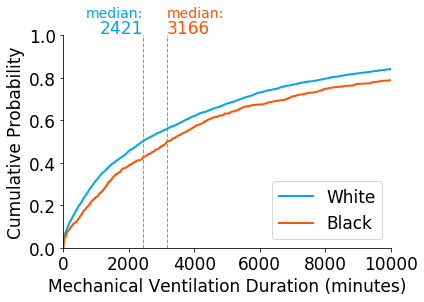

vasopressor
	white: 3426 1599
	black: 457 1684
	p-value: 0.410663077170699


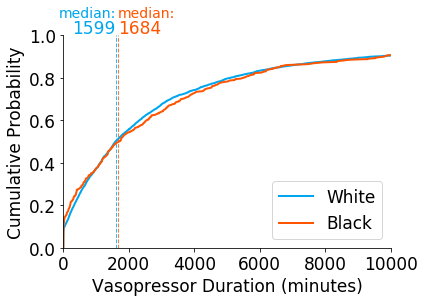

In [7]:


for treatment in T_full.keys():
    print treatment
    
    fig = pl.figure(treatment)
    
    white_median = list_median(T_full[treatment]['White'])
    black_median = list_median(T_full[treatment]['Black'])
    larger_median = min(white_median, black_median)
    
    for i,demographic in enumerate(['White', 'Black']):
        vals = list(T_full[treatment][demographic])
        #print(len(vals))
        #print (np.sort(vals)[int(len(vals)/2)])
        pl.plot(np.sort(vals), np.linspace(0, 1, len(vals), endpoint=False), color=colors[i], label = demographic, lw=2)
        pl.xlim((0,10000))
        pl.ylim((0,1.0))

        median = np.sort(vals)[int(len(vals)/2)]
        pl.axvline(x=median, linestyle="--", lw=1, color=colors[i], alpha=0.8) 
        if median == larger_median:
            p = 10
            h = 'right'
        else:
            p = -10
            h = 'left'
        #h = 'center'
        pl.text(x=median+p, y=1.085, horizontalalignment=h, s="median:", fontsize=14, color=colors[i])
        pl.text(x=median+p, y=1.01, horizontalalignment=h, s=str(int(median)), fontsize=17, color=colors[i])

        i += 1

    ax = pl.subplot(111)    
    ax.spines["top"].set_visible(False)    
    #ax.spines["bottom"].set_visible(False)    
    ax.spines["right"].set_visible(False)    
    #ax.spines["left"].set_visible(False)    
    pl.yticks(fontsize=17)    
    pl.xticks(fontsize=17) 

    pl.legend(loc=4, fontsize=17)
    pl.ylabel("Cumulative Probability", fontsize=17)
    pl.xlabel("%s Duration (minutes)" % captialize(treatment), fontsize=17)

    pl.tight_layout()
    pl.savefig('../images/chapter3/race_mimic_%s.png' % treatment_names[treatment])

    p1 = list(T_full[treatment]['White'])
    p2 = list(T_full[treatment]['Black'])
    w = mannwhitneyu(p1, p2)
    print '\twhite:', len(p1), white_median
    print '\tblack:', len(p2), black_median
    print '\tp-value:', w.pvalue    
    pl.show()

In [8]:
# Table One

from tableone import TableOne
import pandas as pd
import matplotlib.pyplot as plt

# optionally, a categorical variable for stratification
groupby = ['race']

# columns to be summarized
columns = ['discharge_location', 'gender', 'los', 'age'] 

# columns containing categorical variables
categorical = ['discharge_location', 'gender']

# non-normal variables
nonnormal = ['age', 'los']

# alternative labels
labels={'los': 'Length of stay', 'age': 'Age', 'race':'Race',
        'gender':'Gender', 'discharge_location':'Discharge Location'}

# combine all information
grouped_df = pd.merge(apache, demographics, on=['patientunitstayid'])
grouped_df = pd.merge(grouped_df, hospitals, on=['patientunitstayid'])

# create an instance of TableOne with the input arguments
grouped_table = TableOne(grouped_df, columns, categorical, groupby, nonnormal, labels=labels, isnull=False, pval=True)

# view tableone
grouped_table

Grouped by Race                                          
                                             African American         Caucasian    pval           ptest
variable           level                                                                               
n                                                        1703             12705                        
Discharge Location Death                           785 (46.1)       5208 (41.0)  <0.001     Chi-squared
                   Skilled Nursing Facility        918 (53.9)       7497 (59.0)                        
Gender             Female                          867 (50.9)       6226 (49.0)   0.147     Chi-squared
                   Male                            836 (49.1)       6479 (51.0)                        
Length of stay                                 8.7 [4.2,16.2]    8.0 [4.3,14.0]  <0.001  Kruskal-Wallis
Age                                          66.0 [56.0,76.0]  73.0 [63.0,82.0]  <0.001  Kruskal-Wallis
[1] Warning, Hartigan's Dip Test reports possible multimodal distributions for: age, los.
[2] Warning, Tukey test indicates far outliers in: los.
[3] Warning, test for normality reports non-normal distributions for: age, los.